(pelton)=
# Pelton units and forbidden zones

This example illustrates how [generators](generator) can be modelled as Pelton units with multiple [needle_combinations](needle_combination). The same functionality can also be used to model generators with forbidden operating zones.

The model setup for this example is available in the following format:
- pyshop
    - [](pelton_model.py)

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pyshop import ShopSession

#specific imports for this example
from pelton_model import build_model, run_model, calc_p

## Create SHOP session and build a basic model
This example features a single power plant below a reservoir with a single generator. The generator will be modelled as a Pelton unit.

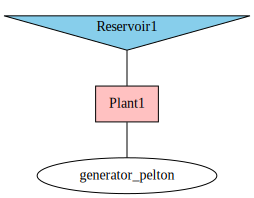

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)
#Display topology to the screen, including generators
display(shop.model.build_connection_tree(display_units=True))

## Defining needle_combination objects

To model a generator as a Pelton generator in SHOP, one only needs to connect one or more needle_combination objects to the generator. The attributes [p_min](needle_combination:p_min), [p_max](needle_combination:p_max), [p_nom](needle_combination:p_nom), and [turb_eff_curves](needle_combination:turb_eff_curves) are usually specified on the generator object, but the needle_combinations take over this role for Pelton units. It is therefore not necessary to add any of these attributes on the Pelton generator object itself. 

Two needle_combination objects are added to this generator, representing two legal production zones. The first needle_combination has an operating range from 7 to 17 MW, while the second needle_combination can produce between 30 and 45 MW. Note that the nominal production is set to the same value for both needle_combinations, though this is only relevant for droop calculations when delivering FCR [reserves](reserves).

In [3]:
pelton = shop.model.generator["pelton"]

#Add first needle_combination, valid from 7 to 17 MW
n1 = shop.model.needle_combination.add_object("N1")
n1.p_min.set(7)
n1.p_max.set(17)
n1.p_nom.set(45)

q = [7.0, 30.0, 49.0]
eff = [87.93, 93.52, 94.95]
c1 = pd.Series(eff,index=q,name=40)

q = [7.0, 30.0, 49.0]
eff = [90.05, 94.09, 95.14]
c2 = pd.Series(eff,index=q,name=42)

q = [7.0, 30.0, 49.0]
eff = [90.9, 94.35, 95.23]
c3 = pd.Series(eff,index=q,name=45)

q = [7.0, 30.0, 49.0]
eff = [90.05, 94.09, 95.14]
c4 = pd.Series(eff,index=q,name=48)

q = [7.0, 30.0, 49.0]
eff = [89.27, 93.88, 95.05]
c5 = pd.Series(eff,index=q,name=50)

n1.turb_eff_curves.set([c1, c2, c3, c4, c5])
pelton.connect_to(n1)

#Add second needle_combination, valid from 30 to 45 MW
n2 = shop.model.needle_combination.add_object("N2")
n2.p_min.set(30)
n2.p_max.set(45)
n2.p_nom.set(45)

q = [68.0, 79.0, 90.0]
eff = [95.40, 95.48, 95.40]
c1 = pd.Series(eff,index=q,name=40)

q = [68.0, 79.0, 90.0, 95.0]
eff = [95.54, 95.63, 95.54, 95.38]
c2 = pd.Series(eff,index=q,name=42)

q = [68.0, 79.0, 90.0, 98.0]
eff = [95.61, 95.76, 95.61, 95.44]
c3 = pd.Series(eff,index=q,name=45)

q = [68.0, 79.0, 90.0, 99.0]
eff = [95.54, 95.63, 95.54, 95.25]
c4 = pd.Series(eff,index=q,name=48)

q = [68.0, 79.0, 90.0, 100.0]
eff = [95.47, 95.55, 95.47, 95.33]
c5 = pd.Series(eff,index=q,name=50)

n2.turb_eff_curves.set([c1, c2, c3, c4, c5])
pelton.connect_to(n2)

### Illegal discharge region
The turbine efficiency curves for both of the needle_combination objects are plotted below. The figure shows that there will be an illegal discharge range between 49 and 68 m3/s since neither of the turbine efficiency curves are defined in this region. Pelton turbines may also have needle_combinations with overlapping turbine efficiency curves in SHOP.

In [4]:
curves_1 = n1.turb_eff_curves.get()
curves_2 = n2.turb_eff_curves.get()

fig = go.Figure()
fig.update_layout(title="Turbine efficiency curves",xaxis_title="Q [m3/s]",yaxis_title="Efficiency [%]")

for i,c in enumerate(curves_1):
    if i == 0:
        fig.add_trace(go.Scatter(x=c.index, y=c.values,mode='markers+lines',line_color="black", marker = {'color': "red",'size': 10},name="N1"))
    else:
        fig.add_trace(go.Scatter(x=c.index, y=c.values,mode='markers+lines',line_color="black", marker = {'color': "red",'size': 10},showlegend=False))

for i,c in enumerate(curves_2):
    if i == 0:
        fig.add_trace(go.Scatter(x=c.index, y=c.values,mode='markers+lines',line_color="black", marker = {'color': "blue",'size': 10},name="N2"))
    else:
        fig.add_trace(go.Scatter(x=c.index, y=c.values,mode='markers+lines',line_color="black", marker = {'color': "blue",'size': 10},showlegend=False))
           
fig.add_trace(go.Scatter(x=[49,49], y=[88,96],mode='lines',line={'color': "gray", 'dash':"dash"}, showlegend=False))
fig.add_trace(go.Scatter(x=[68,68], y=[88,96],mode='lines',line={'color': "gray", 'dash':"dash"}, fill="tonexty", name="Illegal discharge zone"))
            
fig.show()

### Illegal production region

It is possible to calculate the resulting production for each point in the input turbine efficiency curves (the [generator efficiency](generator:gen_eff_curve) is set to a constant 98 % on the generator object). Plotting these input PQ curves together with the p_min and p_max for both needle_combinations, shows that several of the points defined in the turbine efficiency curves will end up in the forbidden production region between 17 and 30 MW. This is not a problem, since SHOP ensures that both discharge and production limits are respected internally when building the PQ curve constraints. Note that the plotted curves are not used directly in SHOP, rather the PQ constraints are built for each time step by interpolating the turbine efficiency curves around the current operating point in q and h space.

It is also possible to have needle_combinations with overlapping production zones in SHOP.

In [5]:
p1_min = n1.p_min.get()
p2_min = n2.p_min.get()
p1_max = n1.p_max.get()
p2_max = n2.p_max.get()

fig = go.Figure()
fig.update_layout(title="Input PQ curves",xaxis_title="Q [m3/s]",yaxis_title="P [MW]")

for i,c in enumerate(curves_1):
    p = calc_p(c)    
    if i == 0:
        fig.add_trace(go.Scatter(x=c.index, y=p,mode='markers+lines',line_color="black", marker = {'color': "red",'size': 10},name="N1"))
    else:
        fig.add_trace(go.Scatter(x=c.index, y=p,mode='markers+lines',line_color="black", marker = {'color': "red",'size': 10},showlegend=False))

for i,c in enumerate(curves_2):
    p = calc_p(c)
    if i == 0:
        fig.add_trace(go.Scatter(x=c.index, y=p,mode='markers+lines',line_color="black", marker = {'color': "blue",'size': 10},name="N2"))
    else:
        fig.add_trace(go.Scatter(x=c.index, y=p,mode='markers+lines',line_color="black", marker = {'color': "blue",'size': 10},showlegend=False))

fig.add_trace(go.Scatter(x=[0,100], y=[p1_min,p1_min],mode='lines',line={'color': "gray", 'dash':"dash"}, name="Production limits"))
fig.add_trace(go.Scatter(x=[0,100], y=[p1_max,p1_max],mode='lines',line={'color': "gray", 'dash':"dash"}, showlegend=False))
fig.add_trace(go.Scatter(x=[0,100], y=[p2_min,p2_min],mode='lines',line={'color': "gray", 'dash':"dash"}, fill="tonexty", name="Illegal production zone"))
fig.add_trace(go.Scatter(x=[0,100], y=[p2_max,p2_max],mode='lines',line={'color': "gray", 'dash':"dash"}, showlegend=False))
        
fig.show()

## Optimization results
Let us now solve the model and inspect the resulting production and commitment choices.

In [6]:
run_model(shop)

The optimized [production](generator:production) and [discharge](generator:discharge) from each hour in the 24 hour optimization is plotted together with the input PQ curves. Most of the results are stored on the same time series attributes as for the regular generator objects; see the documentation for a complete list of output attributes on the needle_combination level. Note that p_max for the lower needle_combination and p_min for the higher needle_combination are constraining in some hours.

In [7]:
p = pelton.production.get()
q = pelton.discharge.get()

fig.add_trace(go.Scatter(x=q.values, y=p.values,mode='markers',marker = {'color': "black",'size': 10}, name="Optimization results"))
fig.update_layout(title="Input PQ curves with optimization results")
fig.show()

The figure below shows a plot of the optimized production and the [committed needle_combination](generator:committed_out) in each hour. The unit is initially off, then needle 1 is committed in hour 16 before needle 2 is committed for the remaining hours. Note that there is no cost for switching between needle_combinations in the optimization, but [start cost](generator:startcost) and [stop cost](generator:stopcost) is still applied when turning the generator on and off.

In [8]:
committed_needle = pelton.committed_out.get()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(title="Optimized production and needle number")
fig.add_trace(go.Scatter(x=committed_needle.index, y=committed_needle.values, name="Committed needle", mode="markers",marker = {'color': "black",'size': 10}), secondary_y=False)
fig.update_yaxes(title_text="Needle number", secondary_y=False)
fig.update_yaxes(title_text="Production [MW]", secondary_y=True)
fig.update_xaxes(tickformat="%H:%M")
fig.add_trace(go.Scatter(x=p.index,y=p.values,mode="lines",name="Production"),secondary_y=True)
fig.show()